# Time-Series & Price Analysis on Avocado Prices in Multiple US markets


<img src="image/avocado_1.png" style="width: 500px;"></img>


Hello, in this notebook we will aim to analyse and predict the change in average avocado prices. The dataset we would be using was downloaded from [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices/downloads/avocado-prices.zip/1)

The Average Price (of avocados) in the dataset reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this dataset.

Some relevant columns in the dataset:

* Date - The date of the observation
* AveragePrice - the average price of a single avocado
* type - conventional or organic
* year - the year
* Region - the city or region of the observation
* Total Volume - Total number of avocados sold
* 4046 - Total number of avocados with PLU 4046 sold
* 4225 - Total number of avocados with PLU 4225 sold
* 4770 - Total number of avocados with PLU 4770 sold


**Date Carried out: May 2019**

## Library Imports

In [25]:
# import pandas for data wrangling and analysis
import pandas as pd
import numpy as np

# import visualization libraries
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# for time series analysis
from fbprophet import Prophet

# import ignore warnings
import warnings
warnings.filterwarnings('ignore')

## The Data

In [26]:
# get the csv file and save it in a variable df
df = pd.read_csv('datasets/avocado.csv')

# inspect the first 5 rows
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


## Data Summary Statistics

In [27]:
# check the summary of the dataframe. useful fir quickly spotting null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


**Summary**
* we can see that this is a rather clean dataframe with no missing values as each column has 18249 records!
* worth noticing that the date column was read as an object datatype instead of datetime

In [28]:
# check the summary statistics of the dataframe
df.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


## Data Preprocessing

**Drop Columns**

* From the Dataframe above, we can see the first column("Unnamed") is the exact copy of the index. 
* We can drop this column as it serves no purpose

**Change Datatype**

* noted earlier, the date column is of object datatype, this should be changed to datetime
* also, splitting the date into 3 seperate columns(year, month and day) will be useful for our analysis

In [29]:
# drop the redundant column  
df.drop(axis=1, columns='Unnamed: 0', inplace= True)

# convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# get the month of each timestamp
df['Month'] = df['Date'].apply(lambda time: time.month)

# get the day of the week from each timestamp
#df['Day'] =  df['Date'].apply(lambda time: time.day)

# set the index to the date column
#df.set_index(df.Date, inplace= True)

# drop the redundant column  
#df.drop(axis=1, columns='Date', inplace= True)

# sorting the index
#df.sort_index(inplace= True)

In [30]:
# check the dataframe
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11


**Perfect!**

## Exploratory Data Analysis

### Price Distribution by Type

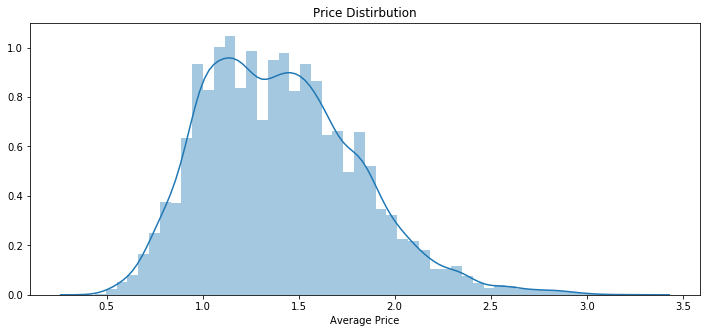

In [31]:
plt.figure(figsize=(12,5))
plt.title("Price Distirbution")
ax = sns.distplot(df["AveragePrice"], axlabel='Average Price')

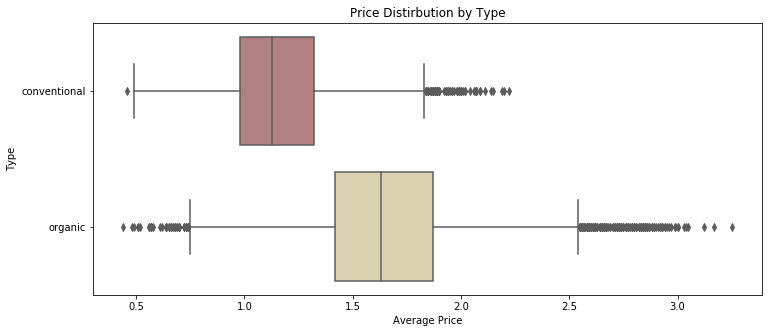

In [32]:
plt.figure(figsize=(12,5))
plt.title("Price Distirbution by Type")
sns.boxplot(y="type", x="AveragePrice", data=df, palette = 'pink')
plt.xlabel('Average Price');
plt.ylabel('Type');

**Summary**

* Organic avocados are more expensive. 
* This could be because thier cultivation is more expensive 
* Another reason could be due to the recent fad in healthy eating, natural products will typicaly be more expensive. 

But it is likely that the price of avocado depends not only on the type. Let's look at the price of avocado from different regions in different years. Let's start with organic avocados

### Price by Region: Organic Avo

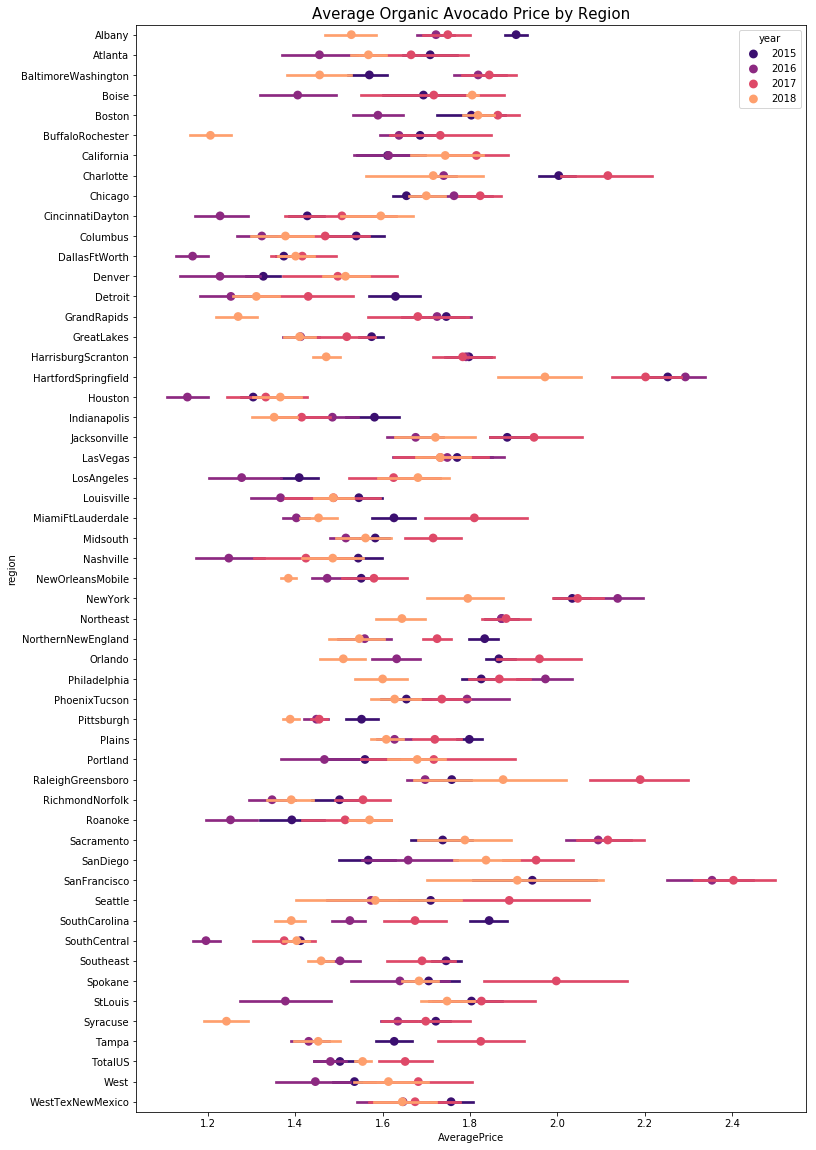

In [33]:
# get a mask of the organic region
organic = df.type == 'organic'

# create a factorplot based off this
plt.figure(figsize=(12,20))
sns.pointplot('AveragePrice', 
               'region',  
               data= df[organic],
               hue = 'year',
               palette='magma', 
               size = 13,
               aspect=0.8,
               join = False);
# add a title
plt.title("Average Organic Avocado Price by Region",{'fontsize':15});

**Summary**
<img src="image/avocado_2.png" alt="Drawing" style="width: 300px;"/>
* San Francisco, 2017 saw a record high price for organic avocados. 
* This was due surging global demands and reduced harvests from major producers according to [BBC](https://www.bbc.com/news/business-39768480)

### Price by Region: Conventional Avo

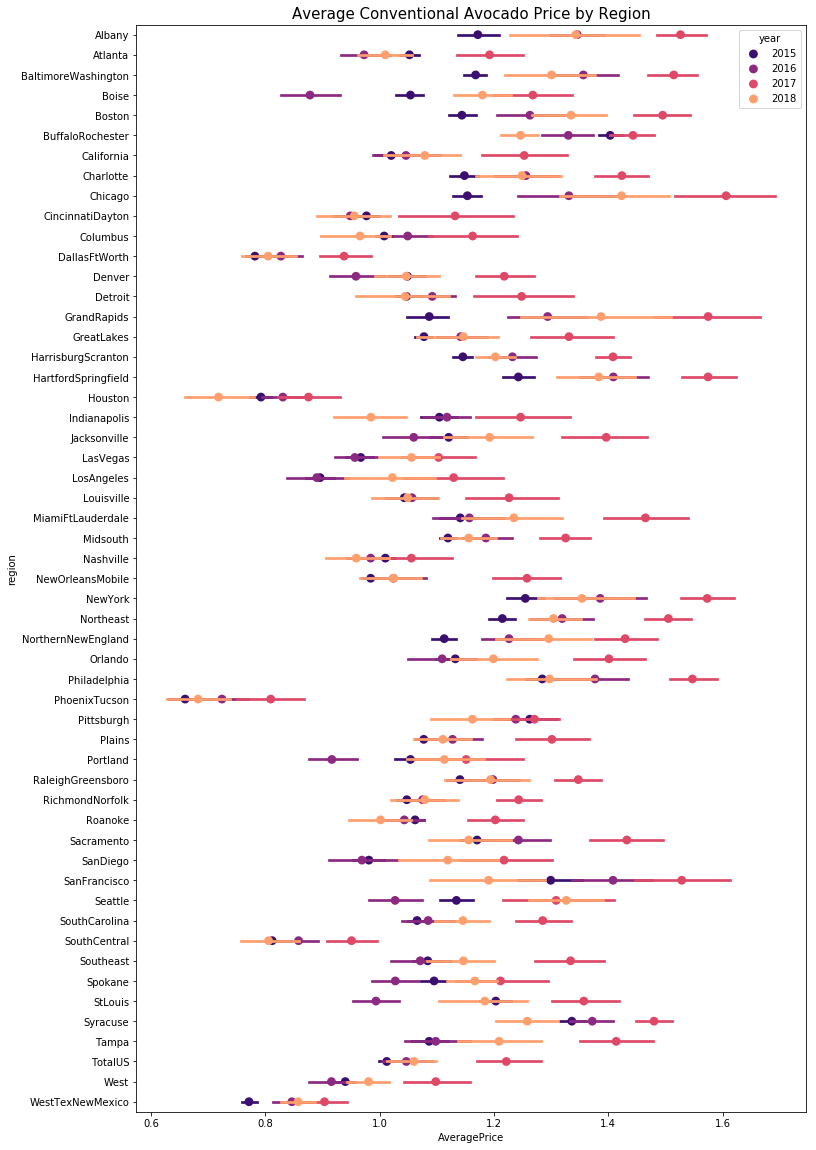

In [34]:
# get a mask of the organic region
conventional = df.type == 'conventional'

# create a factorplot based off this
plt.figure(figsize=(12,20))
sns.pointplot('AveragePrice', 
               'region',  
               data= df[conventional],
               hue = 'year',
               palette='magma', 
               size = 13,
               aspect=0.8,
               join = False);
# add a title
plt.title("Average Conventional Avocado Price by Region",{'fontsize':15});

**Summary**

* The situation with the price increase in 2017 also affected conventional avocados.

## Time Series Analysis With Prophet

[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) is a forecasting package designed by Facebook for analyzing time series with daily observations that display patterns on different time scales.

### Formating The Data

In order to use Prophet, our data needs to be formatted in a certain way.
* dataframe must consist of a datetime index and a single column.
* the date column must be called ‘ds’ and the value column we want to predict should be called ‘y’.
* we then create a prophet model and fit the data into it.

In [35]:
# selecting the neccesary columns
df = df.loc[:,["Date","AveragePrice"]]

# rename the column names
df.rename(columns = {'Date': 'ds',
                     'AveragePrice': 'y'}, inplace = True)

# view the formated data
df.head()

,ds,y
0,2015-12-27,1.33
1,2015-12-20,1.35
2,2015-12-13,0.93
3,2015-12-06,1.08
4,2015-11-29,1.28


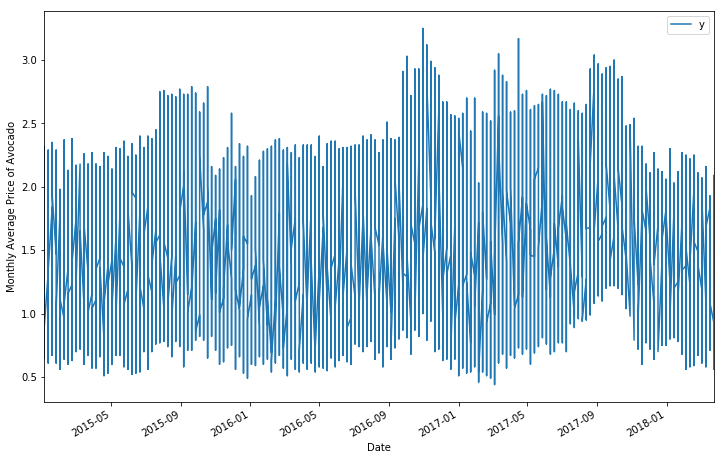

In [36]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Average Price of Avocado')
ax.set_xlabel('Date')

plt.show()

**With our data now prepared, we are ready to use the Prophet library to produce forecasts of our time series**

### Instantiate Prophet

In [37]:
# instantiate the Phophet model and set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width=0.95)

# fit the model to our data, df
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Future Predictions

In order to get forecasts of our time series, we must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions.

Prophet provides the _make_future_dataframe_ helper function to help with this.

In [38]:
# instantiate the helper function and set the datestamp to 36
future = model.make_future_dataframe(periods=36, freq='MS')

# see the last 5 dates in the future
future.tail()

,ds
18280,2020-11-01
18281,2020-12-01
18282,2021-01-01
18283,2021-02-01
18284,2021-03-01


When working with Prophet, it is important to consider the frequency of our time series.

Because we are working with monthly data, we clearly specified the desired frequency of the timestamps

In this case, we are looking to make predictions 3 years into the future.

### Making Predictions

The _forecast_ object  is a new dataframe that includes a column "yhat" with the forecast, as well as columns for components and uncertainty intervals

In [39]:
# instantiate the forecast function and fit the future dataframe into it
forecast = model.predict(future)

# subset of the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
18280,2020-11-01,0.814836,-0.945117,2.434266
18281,2020-12-01,0.654326,-1.132792,2.223975
18282,2021-01-01,0.536322,-1.333445,2.198075
18283,2021-02-01,0.474766,-1.464472,2.271171
18284,2021-03-01,0.514092,-1.449917,2.442250


Prophet returns a large DataFrame but we only select the columns most relevant to forecasting, which are:

* ds: the datestamp of the forecast
* yhat: predicted future values 
* yhat_lower: lower bound of our forecasts
* yhat_upper: upper bound of our forecasts

### Visualizing The Future of Avocado Prices

#### Yearly Trend

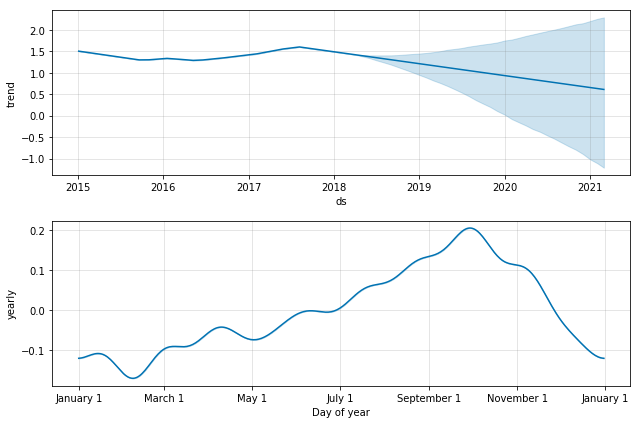

In [40]:
model.plot_components(forecast);

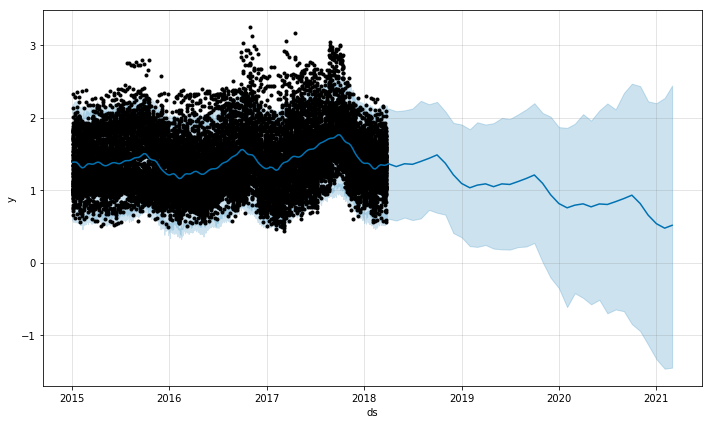

In [41]:
#model.plot(forecast, xlabel= 'Year', ylabel= 'Average Prices')
fig1 = model.plot(forecast);

### Conclusion

<img src="image/happy_avo.gif" alt="Drawing" style="width: 350px;"/>

Our Model predicted the rising prices of Avocado will go come in the following years. Well into 2019 we can see this might not be the case due to external forces.

President Trump's [threat](http://fortune.com/2019/04/03/trump-mexico-border-avocado-price/) to close the Mexican boarder will most likely see the prices of avocados (and other fruits) going up as they are the biggest suppliers of fruits to the US.